# Прогнозирование задержек вылетов рейсов

## Введение

Наверное многие при отправлении в отпуск или командировку беспокоятся, как бы не опоздать на рейс. А если рейс утренний — то часто приходится искать компромисс между продолжительностью сна и ранним приездом в аэропорт. Бывает и так, что при планировании поездок приходится лететь с пересадками, и встаёт вопрос о том, хватит ли 40-50-60 минут, чтобы успеть на следующий рейс. Если бы при ответе на все эти вопросы у нас под рукой была информация, задержится ли вылет нашего рейса, скажем, на 15 минут — мы бы могли принять более взвешенное решение. Или просто могли бы спать на 15 минут дольше. В настоящем исследовании попробуем спрогнозировать задержку вылета рейса на 15 минут ради уменьшения количества синяков под глазами.

## 1. Описание данных

За основу для анализа берём этот датасет с [данными](https://www.kaggle.com/usdot/flight-delays) о задержках внутренних рейсов американских авиакомпаний за 2015 год с Kaggle. К этому датасету добавим также [информацию](http://ourairports.com/data/) об аэропортах и взлётных полосах, а также историческую [информацию](https://www.ncdc.noaa.gov/isd/data-access) о погоде в аэропортах вылета и назначения.

В исходном датасете, в файле ``flights.csv``, присутствуют следующие признаки:

- Признаки, которые мы будем использовать:
    - **YEAR**, **MONTH**, **DAY** — год, месяц и число, в которые выполнялся рейс
    - **DAY_OF_WEEK** — день недели вылета
    - **AIRLINE** — двухбуквенный код авиакомпании
    - **ORIGIN_AIRPORT** — код аэропорта вылета
    - **SCHEDULED_DEPARTURE** — запланированное время отбытия от гейта
    - **DEPARTURE_DELAY** — задержка отбытия, ``DEPARTURE_TIME - SCHEDULED_DEPARTURE``
    - **DISTANCE** — расстояние между аэропортами вылета и назанчения (в милях)
- Признаки, которые мы не будем использовать для предсказаний:
    - **FLIGHT_NUMBER** — номер рейса
    - **TAIL_NUMBER** — бортовой номер самолёта, выполняющего рейс
    - **DESTINATION_AIRPORT** — код аэропорта назначения
    - **DEPARTURE_TIME** — реальное время отбытия от гейта
    - **TAXI_OUT** — время, в течение которого самолёт осуществлял руление
    - **WHEELS_OFF** — время вылета
    - **SCHEDULED_TIME** — время полёта по плану
    - **ELAPSED_TIME** — действительное время полёта (от гейта до гейта)
    - **AIR_TIME** — время в воздухе (между взлётом и посадкой)
    - **WHEELS_ON** — время посадки
    - **TAXI_IN** — время руления в аэропорту назначения
    - **SCHEDULED_ARRIVAL** — запланированное время прибытия к гейту в аэропорту назначения
    - **ARRIVAL_TIME** — реальное время прибытия к гейту в аэропорту назначения
    - **ARRIVAL_DELAY** — задержка прибытия, ``ARRIVAL_TIME - SCHEDULED_ARRIVAL``
    - **DIVERTED** — самолёт приземлился не в аэропорту назначения
    - **CANCELLED** — рейс был отменён
    - **CANCELLATION_REASON** — код причины отмены рейса (A: авиакомпания, B: погода, C: National Airspace System, D: безопасность)
    - **AIR_SYSTEM_DELAY** — величина задержки в минутах из-за National Airspace System
    - **SECURITY_DELAY** — величина задержки в минутах в связи с вопросами безопасности
    - **AIRLINE_DELAY** — величина задержки в минутах из-за авиакомпании
    - **LATE_AIRCRAFT_DELAY** — величина задержки в минутах из-за задержки предыдущего рейса этого же самолёта
    - **WEATHER_DELAY** — величина задержки в минутах из-за погоды

Кроме того, в датасете содержатся ещё два файла — с информацией об аэропортах и расшифровкой кодов авиакомпаний. Информацию об аэропортах мы использовать не будем, поскольку есть альтернативный список аэропортов с большим количеством информации. Файл ``airlines.csv`` имеет следующие поля:

- **IATA_CODE** — код авиакомпании (соответствует полю ``AIRLINE`` из файла со списком рейсов)
- **AIRLINE** — название авиакомпании

## 2. Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Загружаем датасет, смотрим типы данных:

In [2]:
df = pd.read_csv('Data/US2015/flights.csv')

/home/haber/anaconda3/envs/mlcourse/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

Как видим, всего в датасете есть информация о 5.819kk совершённых рейсов.

Выкинем лишние поля

In [4]:
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 
         'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
         'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)

#### Целевая переменная

Сформируем целевую переменную из поля ``DEPARTURE_DELAY``.

In [5]:
df['target'] = df['DEPARTURE_DELAY'] >= 15

In [6]:
print('{:.2%} рейсов было задержано на 15 и более минут'.format(df['target'].sum() / len(df)))

18.17% рейсов было задержано на 15 и более минут


Поскольку целевая переменная может принимать 2 значения, будем решать задачу классификации

#### Основные причины задержек

Посмотрим распределение причин задержек рейсов (долю рейсов, в которых данная причина указана).

In [7]:
(df.loc[df['target'], 
        ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
         'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] > 0).sum() / df['target'].sum()

AIR_SYSTEM_DELAY       0.318532
SECURITY_DELAY         0.002619
AIRLINE_DELAY          0.476248
LATE_AIRCRAFT_DELAY    0.492760
WEATHER_DELAY          0.055164
dtype: float64

Во-первых, видим, что сумма всех причин задержек больше 1, то есть одновременно несколько факторов могут приводить к задержке. Во-вторых, наиболее вероятными причинами задержки является задержка прибытия предыдущего рейса или что-то связанное с авиакомпанией (подготовка самолёта, ожидание пасажиров или экипажа, удаление с борта буйных пасспажиров и т.п., на [сайте](http://aspmhelp.faa.gov/index.php/Types_of_Delay) Федерального Авиационного Агентства есть список с описанием причин).

#### Аэропорты и авиакомпании

Посмотрим, какие аэропорты имеются в датасете:

In [8]:
unique_airports = set(df['ORIGIN_AIRPORT'].unique().tolist() + df['DESTINATION_AIRPORT'].unique().tolist())
print('В датасете присутствует информация о {} аэропортах:'.format(len(unique_airports)))
print(unique_airports)

В датасете присутствует информация о 931 аэропортах:
{'13296', '11267', '12007', 'BUF', 'EAU', '10781', '14842', 10257, '10529', 10268, 'DTW', 'VLD', 12323, '13344', '11577', '13486', '11637', 10279, '13873', 'MLI', 12335, '14520', 12339, '14057', 12343, 'BLI', '11995', 'MSY', 10299, '15048', 'BZN', '13891', '10631', '11423', '12265', 10333, '13277', 'RDM', 'HNL', '10561', '13184', 12389, 'ISN', 12391, 'LAR', '14986', 'ITH', '10268', 12402, 14457, 'JAN', 'STX', '12889', 10372, '15919', 'RNO', 'JLN', 'CNY', '10333', 'AVP', 14487, 14489, 12441, 14492, 10397, 'ATW', 12448, 12451, 'MLU', 'RKS', '14685', '11203', '11274', 'TTN', 10408, '14709', 'AGS', 10423, '13256', '11537', 14520, 14524, 'LNK', 12478, 10431, '14952', 'GTF', 'IMT', 10434, 'SBN', '14098', 'IAH', 14543, '14256', 'EKO', 'SUN', 'PIH', '11146', 12511, '15096', 10469, 12519, '10785', 14570, 12523, 14574, 14576, '10713', '10926', 14588, 'DAB', 'AKN', 'GRK', 'BUR', 'ABQ', 'HOB', '10146', 'BJI', '13230', '11996', '15041', '12280', 

Цифровые коды аэропортов — это какая-то проблема с данными, другой вид кодировки. Находим следующий [список](https://github.com/srcole/flightdelay/tree/master/airportcodes) аэропортов с соответствием трёхбуквенных и цифровых кодов. По ссылке два списка аэропортов — с полями **Code** (в одном файле это IATA код, в другом цифровой) и **Description** (название аэропорта в обоих файлах). Заменим цифровые коды на буквенные IATA коды.

In [9]:
codes_num = pd.read_csv('Data/raw/L_AIRPORT_ID.csv')
codes_iata = pd.read_csv('Data/raw/L_AIRPORT.csv')

class Vocab(dict):
    def __missing__(self, key):
        return key

fix_vocab = Vocab(
    pd.merge(codes_num, codes_iata, on='Description')[['Code_x', 'Code_y']] \
            .astype(str).set_index('Code_x').to_dict()['Code_y'])

df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str).map(fix_vocab)
df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype(str).map(fix_vocab)

Попробуем ещё раз:

In [10]:
unique_airports = set(df['ORIGIN_AIRPORT'].unique().tolist() + df['DESTINATION_AIRPORT'].unique().tolist())
print('В датасете присутствует информация о {} аэропортах:'.format(len(unique_airports)))
print(unique_airports)

В датасете присутствует информация о 323 аэропортах:
{'HIB', 'WYS', 'STL', 'RDU', 'SLC', 'DAL', 'TPA', 'LIH', 'BUF', 'EAU', 'CAK', 'TRI', 'PBG', 'SGU', 'EYW', 'OGG', 'PDX', 'RHI', 'SMX', 'DHN', 'ORH', 'EVV', 'ANC', 'CMH', 'OTH', 'CIU', 'DTW', 'MSN', 'VLD', 'GJT', 'ILG', 'MLI', 'PSP', 'TYS', 'GCC', 'MQT', 'APN', 'BQN', 'SIT', 'ADQ', 'UST', 'BLI', 'PAH', 'MSY', 'MRY', 'MVY', 'EWR', 'TUL', 'MEM', 'BZN', 'JAX', 'OMA', 'ESC', 'HOU', 'BIL', 'FAY', 'LBB', 'HYA', 'BIS', 'GPT', 'PSE', 'MYR', 'CVG', 'GRR', 'ICT', 'DIK', 'FAR', 'LGA', 'TXK', 'EWN', 'BFL', 'RDM', 'HNL', 'CHA', 'LAS', 'ISN', 'BTR', 'MDW', 'LAR', 'TWF', 'FLG', 'BGM', 'SYR', 'CDV', 'ITH', 'DLG', 'KOA', 'OAJ', 'MSP', 'LEX', 'BGR', 'JAN', 'STX', 'GEG', 'PSC', 'SCC', 'DLH', 'VEL', 'ASE', 'GSO', 'MMH', 'BHM', 'RNO', 'ADK', 'JLN', 'ECP', 'CNY', 'JFK', 'BMI', 'IND', 'AVP', 'SBA', 'FSD', 'ELM', 'LSE', 'ATW', 'YAK', 'ACT', 'CHO', 'ELP', 'MLU', 'MFE', 'MCO', 'DVL', 'MCI', 'TTN', 'RKS', 'CRW', 'BRW', 'AGS', 'TLH', 'CRP', 'LNK', 'SAF', 'GTF', '

Гораздо лучше. Теперь посмотрим на авиакомпании.

In [11]:
print('Авиакомпании, представленные в датасете: {} (всего {} штук)'.format(df['AIRLINE'].unique().tolist(),
                                                                           len(df['AIRLINE'].unique().tolist())))

Авиакомпании, представленные в датасете: ['AS', 'AA', 'US', 'DL', 'NK', 'UA', 'HA', 'B6', 'OO', 'EV', 'MQ', 'F9', 'WN', 'VX'] (всего 14 штук)


Здесь всё правильно, сокращения совпадают с приведёнными в файле ``airlines.csv``. Не будем доставать оттуда полные названия компаний, чтобы потом их было проще кодировать для обучения.

## 3. Визуальный анализ 

#### Распределение вероятностей задержек по времени

Для удобства преобразуем данные, связанные с датой и временем к ``datetime`` формату.

In [12]:
def get_time(x):
    hour = int(x[:2])
    minute = int(x[-2:])
    return dt.time(hour, minute)

In [13]:
%%time
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4).apply(get_time)

CPU times: user 11.1 s, sys: 120 ms, total: 11.2 s
Wall time: 11.2 s


In [14]:
%%time
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

CPU times: user 2.87 s, sys: 228 ms, total: 3.1 s
Wall time: 3.1 s


In [15]:
# %%time
# df['DATETIME'] = df.apply(lambda x: dt.datetime.combine(x['DATE'], x['SCHEDULED_DEPARTURE']), axis=1)

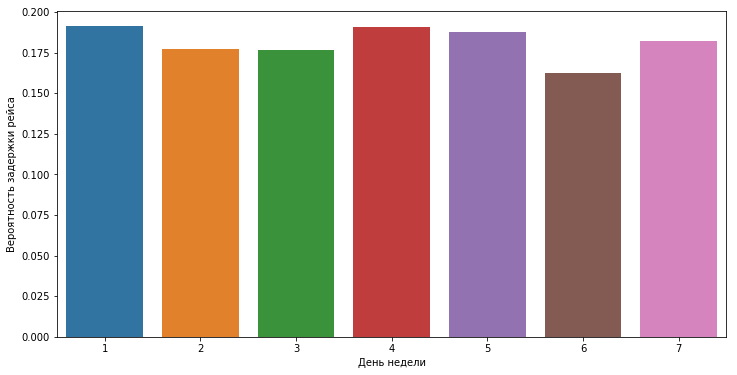

In [16]:
gr = df.groupby('DAY_OF_WEEK')['target'].agg(['sum', 'count'])
xs = gr.index.values
ys = gr['sum'] / gr['count']

plt.figure(figsize=(12, 6))
sns.barplot(xs, ys);

plt.xlabel('День недели');
plt.ylabel('Вероятность задержки рейса');

Существенной зависимости от дня недели нет.

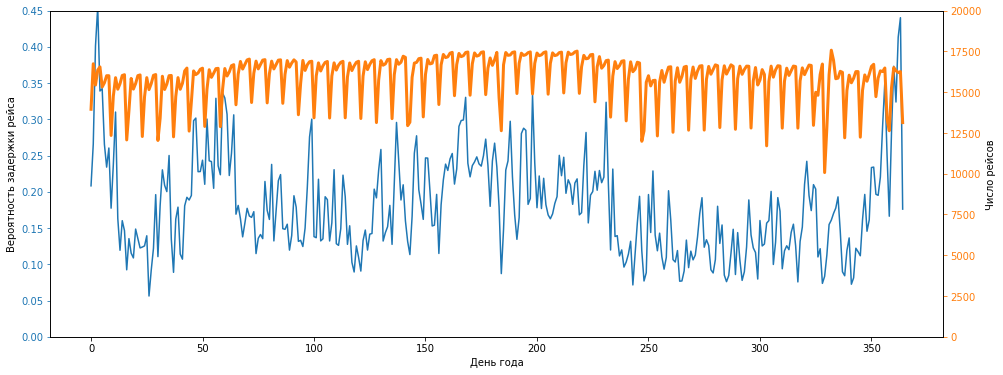

In [17]:
gr = df.groupby(pd.Grouper(key='DATE', freq='D'))['target'].agg(['sum', 'count'])
ys = gr['sum'] / gr['count']

fig, ax1 = plt.subplots(figsize=(16, 6))
plt.plot(np.arange(len(ys)), ys);
plt.xlabel('День года');
plt.ylabel('Вероятность задержки рейса');
plt.tick_params('y', colors='C0')
plt.ylim(0, 0.45)

ax2 = ax1.twinx()
ys = gr['count']
plt.plot(np.arange(len(ys)), ys, lw=3, color='C1');
plt.ylim(0, 20000);
plt.ylabel('Число рейсов');
plt.tick_params('y', colors='C1');

Интересно, что в районе нового года и рождества вероятность задержки рейса существенно растёт, хотя количество выполняемых рейсов остаётся на обычном уровне. Возможно это связано с тем, что в аэропортах остаётся работать очень небольшое количество работников.

То же самое, но по неделям:

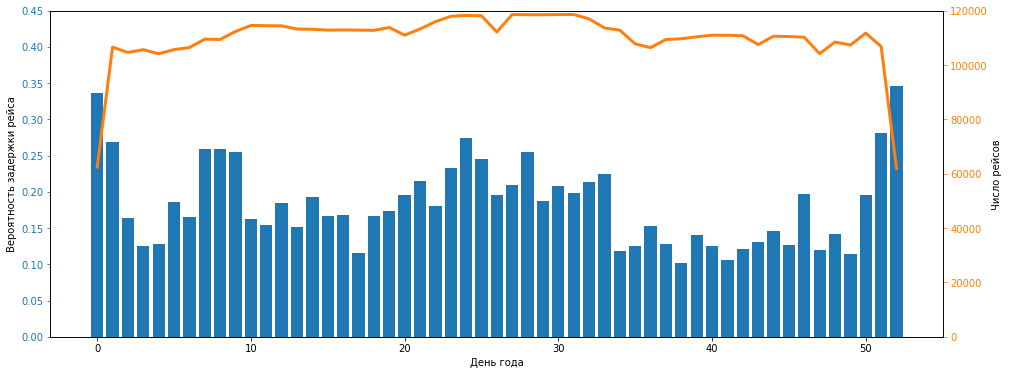

In [18]:
gr = df.groupby(pd.Grouper(key='DATE', freq='W'))['target'].agg(['sum', 'count'])
ys = gr['sum'] / gr['count']

fig, ax1 = plt.subplots(figsize=(16, 6))
plt.bar(np.arange(len(ys)), ys);
plt.xlabel('День года');
plt.ylabel('Вероятность задержки рейса');
plt.tick_params('y', colors='C0')
plt.ylim(0, 0.45)

ax2 = ax1.twinx()
ys = gr['count']
plt.plot(np.arange(len(ys)), ys, lw=3, color='C1');
plt.ylim(0, 120000);
plt.ylabel('Число рейсов');
plt.tick_params('y', colors='C1');

Введём дополнительно время вылета в часах (дробных и целых):

In [29]:
df['DEP_HOUR_FLOAT'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour + x.minute/60)
df['DEP_HOUR_INT'] = df['DEP_HOUR_FLOAT'].astype(int)

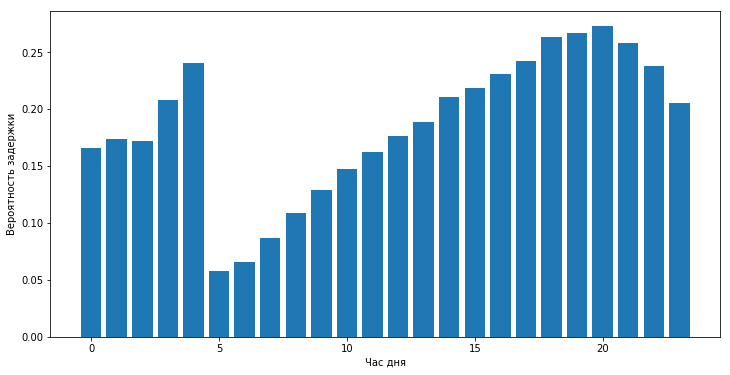

In [20]:
gr = df.groupby('DEP_HOUR_INT')['target'].agg(['sum', 'count'])
xs = gr.index.values
ys = gr['sum']/gr['count']

plt.figure(figsize=(12, 6))
plt.bar(xs, ys);

plt.xlabel('Час дня');
plt.ylabel('Вероятность задержки');

Видим, что в течение дня вероятность задержки рейса существенно меняется. Возможно это связано с тем, что ближе к концу дня задержки рейсов накапливаются и задержка предыщих рейсов приводит к задержке последующих. В таком случае количество вероятность задержки данного рейса будет тем больше, чем больше рейсов уже вылетело из данного аэропорта на текущий момент. Посмотрим:

In [21]:
%%time
df['FLIGHTS_BEFORE'] = df.groupby(['DATE', 'ORIGIN_AIRPORT'])['DATE'].transform(lambda x: list(range(len(x))))

CPU times: user 22.2 s, sys: 108 ms, total: 22.3 s
Wall time: 22.3 s


Построим вероятность задержки по логарифмически распределённым корзинам:

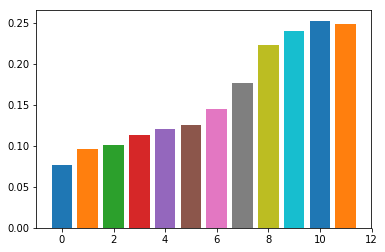

In [22]:
bin_id = np.digitize(df['FLIGHTS_BEFORE'],
                     bins=np.logspace(0, 10, 11, base=2))

df['FLIGHT_BEFORE_BIN'] = bin_id

for b in np.unique(bin_id):
    flt = bin_id == b
    plt.bar(b, np.sum(df.loc[flt, 'target']) / np.sum(flt))

Действительно — чем больше рейсов вылетело из аэропорта, тем выше вероятность задержки текущего рейса.

Построем распределение вероятности задержки одновременно от часа вылета и корзины по количествую предшествующих вылетов, в которую попадает данный рейс.

In [53]:
def gen_meshgrid(x, y, z):
    ux = np.unique(x)
    uy = np.unique(y)
    [X, Y] = np.meshgrid(ux, uy)
    
    def getz(x1, y1):
        fltx = x == x1
        flty = y == y1
        try:
            idx = (fltx & flty).tolist().index(True)
        except ValueError:
            idx = 0
        return idx
    
    Z = np.array([z[getz(x1, y1)] for x1, y1 in zip(X.flatten(), Y.flatten())])
    Z.shape = X.shape
    
    return (X, Y, Z)

In [58]:
gr = df.groupby(['DEP_HOUR_INT', 'FLIGHT_BEFORE_BIN'])['target'].agg(['sum', 'count']).reset_index()
xs = gr['DEP_HOUR_INT']
ys = gr['FLIGHT_BEFORE_BIN']
zs = gr['sum'] / gr['count']

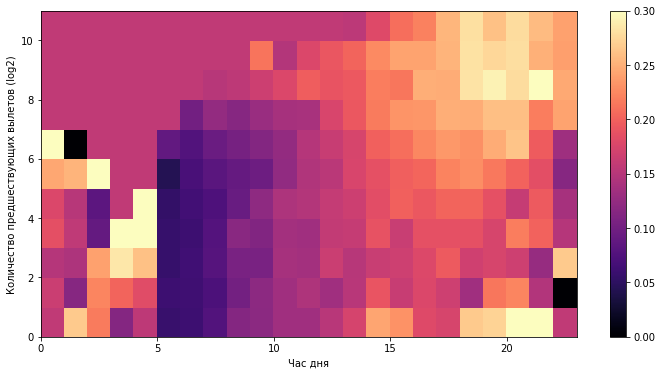

In [61]:
X, Y, Z = gen_meshgrid(xs, ys, zs)

plt.figure(figsize=(12, 6))
plt.pcolor(X, Y, Z, cmap='magma')
plt.colorbar();
plt.clim(0, 0.3);
plt.xlabel('Час дня');
plt.ylabel('Количество предшествующих вылетов (log2)');

Видно, что у тех вылетающих вечером рейсов, перед которыми было мало других вылетов, ниже вероятность задержки.

Посмотрим также как меняется вероятность задержки в зависимости от дня недели и времени суток.

In [63]:
gr = df.groupby(['DEP_HOUR_INT', 'DAY_OF_WEEK'])['target'].agg(['sum', 'count']).reset_index()
xs = gr['DEP_HOUR_INT']
ys = gr['DAY_OF_WEEK']
zs = gr['sum'] / gr['count']

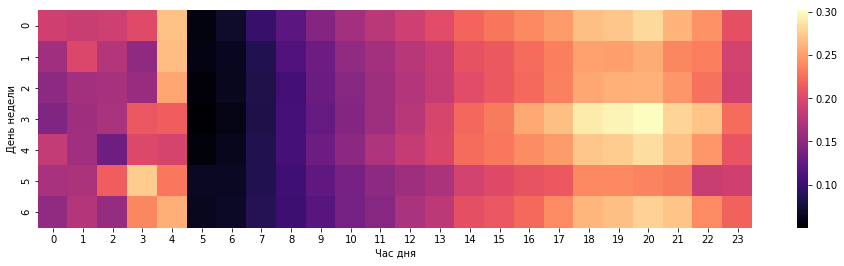

In [64]:
X, Y, Z = gen_meshgrid(xs, ys, zs)

plt.figure(figsize=(16, 4))
sns.heatmap(Z, cmap='magma');
plt.xlabel('Час дня');
plt.ylabel('День недели');

Видно, что в целом вероятности довольно однородны в течение недели. Немного выделяются вечер четверга (вероятность задержки выше) и вечер субботы (вероятность ниже).

#### Распределение задержек по авиакомпаниям

Посмотрим на проценты задержек у разных авикомпаний.

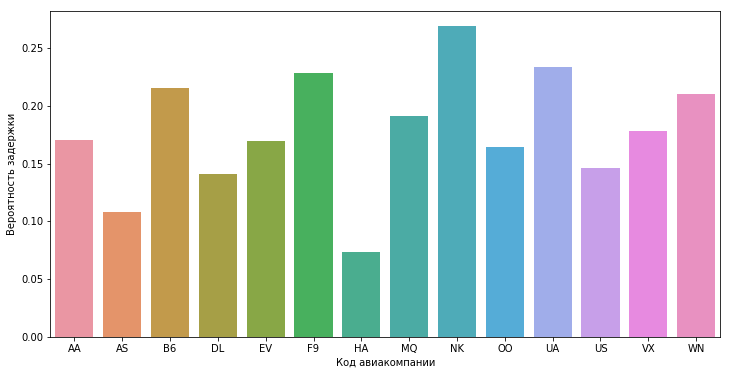

In [66]:
gr = df.groupby('AIRLINE')['target'].agg(['sum', 'count'])

plt.figure(figsize=(12, 6))
xs = gr.index.values
ys = gr['sum'] / gr['count']
sns.barplot(xs, ys);

plt.xlabel('Код авиакомпании');
plt.ylabel('Вероятность задержки');

#### Влияние дальности перелёта

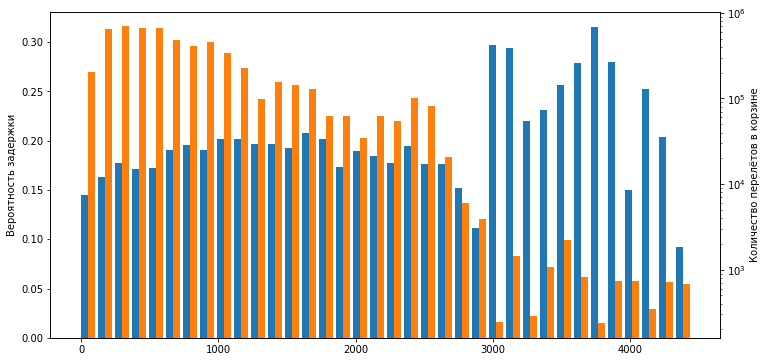

In [111]:
bins = np.histogram(df['DISTANCE'], bins=40)[1]
bin_id = np.digitize(df['DISTANCE'], bins=bins)

fig, ax1 = plt.subplots(figsize=(12, 6))
for bid, b in zip(np.unique(bin_id), bins):
    flt = bin_id == bid
    plt.bar(b, np.sum(df.loc[flt, 'target']) / np.sum(flt), width=50, color='C0')

plt.ylabel('Вероятность задержки');    

ax1.twinx()
for bid, b in zip(np.unique(bin_id), bins):
    flt = bin_id == bid
    plt.bar(b+50, np.sum(flt), width=50, color='C1')
    
plt.yscale('log')    

plt.xlabel('Дальность перелёта');
plt.ylabel('Количество перелётов в корзине');

Интересно, что для рейсов дальностью больше 3000 миль, резко увеличивается вероятность задержек. По-видимому такие перелёты всегда сопровождаются более тщательной проверкой и подготовкой самолёта. 

In [118]:
(df.loc[(df['DISTANCE'] > 3000) & (df['target']),
        ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
         'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] > 0).sum() / ((df['DISTANCE'] > 3000) & (df['target'])).sum()

AIR_SYSTEM_DELAY       0.229067
SECURITY_DELAY         0.000868
AIRLINE_DELAY          0.582646
LATE_AIRCRAFT_DELAY    0.200868
WEATHER_DELAY          0.032538
dtype: float64

И действительно, в причинах задержек дальних рейсов единолично доминируют причины, связанные с авиакомпанией.

## 4. Подготовка фич 

Достанем ещё несколько фич из таблицы с аэропортами. Добавим координаты аэропорта, его размер, высоту над уровнем моря, наличие планового обслуживания и регион, в котором он находится (страна и штат США).

In [121]:
airport_df = pd.read_csv('Data/raw/airports.csv').set_index('id')

lat_vocab, lon_vocab, type_vocab = {}, {}, {}
elev_vocab, region_vocab, service_vocab = {}, {}, {}
for airport in unique_airports:
    flt = (airport_df['iata_code'] == airport) & (airport_df['type'] != 'closed')
    lat_vocab[airport] = airport_df.loc[flt, 'latitude_deg'].values[0]
    lon_vocab[airport] = airport_df.loc[flt, 'longitude_deg'].values[0]
    type_vocab[airport] = airport_df.loc[flt, 'type'].values[0]
    elev_vocab[airport] = airport_df.loc[flt, 'elevation_ft'].values[0]
    region_vocab[airport] = airport_df.loc[flt, 'iso_region'].values[0]
    service_vocab[airport] = airport_df.loc[flt, 'scheduled_service'].values[0]

df['ORIGIN_LAT'] = df['ORIGIN_AIRPORT'].map(lat_vocab)
df['ORIGIN_LON'] = df['ORIGIN_AIRPORT'].map(lon_vocab)
df['ORIGIN_SIZE'] = df['ORIGIN_AIRPORT'].map(type_vocab)
df['ORIGIN_ELEV'] = df['ORIGIN_AIRPORT'].map(elev_vocab)
df['ORIGIN_REGION'] = df['ORIGIN_AIRPORT'].map(region_vocab)
df['ORIGIN_SERVICE'] = df['ORIGIN_AIRPORT'].map(service_vocab)

Добавим в датафрейм день года.

In [122]:
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear

## 5. Выбор модели и метрики

Поскольку решается задача бинарной классификации с несбалансированными классами, будем пользоваться метрикой ROC AUC. Обучать будем модели на основе деревьев — ``XGBoostClassifier``.

In [197]:
import random

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Для начала соберём пайплайн для предобработки данных и обучения модели.

In [124]:
class ItemSelector(BaseEstimator):
    def __init__(self, colname):
        self.colname = colname
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        if x[self.colname].dtype == 'object':
            return x[self.colname].values
        else:
            return x[self.colname].values.astype('float64').reshape(-1, 1)

In [240]:
xgb_pipeline = Pipeline([
    ('union', FeatureUnion([
        ('dep_hour', ItemSelector('DEP_HOUR_FLOAT')),
        
        ('orig_airport', Pipeline([
            ('selector', ItemSelector('ORIGIN_AIRPORT')),
            ('ohe', CountVectorizer())
        ])),
        
        ('airline', Pipeline([
            ('selector', ItemSelector('AIRLINE')),
            ('ohe', CountVectorizer())
        ])),
        
        ('distance', ItemSelector('DISTANCE')),
    ])),
    
    ('xgb', XGBClassifier(random_state=241))
])

``ItemSelector`` выделяет из всего датафрейма нужную фичу и отдаёт её для дальнейшей обработки, либо просто для добавления в конечную матрицу признаков-наблюдений.

``CountVectorizer`` в данном случае работает как OneHotEncoder для кода аэропорта, кода авиакомпании, размера аэропорта, наличия сервиса в аэропорту. Для региона (формат *КОДСТРАНЫ-ШТАТ*) ``CountVectorizer`` достаёт отдельно страну и отдельно штат.

#### Разделение на обучающую и тестовую выборки

Вообще говоря, мы бы хотели научиться предсказывать будущие задержки рейсов. Однако, поскольку данные у нас есть только за один год, в течение которого наблюдаются сезонные колебания, разделять выборку на обучающую и тестовую по времени будет неверно — в обучающей выборке не будет особенностей, связанных, скажем, с рождественскими праздниками. Можно разделять по аэропортам (например, разделив их на западную и восточную части), но в таком случае также из обучающей выборки потеряются особенности, представленные в тестовой. Поэтому будем разобъём весь датасет на группы с уникальными парами (день, аэропорт) и разделим датасет по ним. В таком случае в обучающей выборке у нас будут присутствовать все даты и все аэропорты, но в то же время, мы избежим утечек данных о конкретном аэропорте в конкретный день.

In [224]:
unique_groups = list(df.groupby(['DAY_OF_YEAR', 'ORIGIN_AIRPORT']).groups.keys())

In [242]:
%%time
np.random.seed(27)
train_size = int(len(unique_groups) * 0.4)
train_groups = random.sample(unique_groups, train_size)
test_groups = list(set(unique_groups) - set(train_groups))
df_train = df.set_index(['DAY_OF_YEAR', 'ORIGIN_AIRPORT'], drop=False).loc[train_groups].reset_index(drop=True)
df_test = df.set_index(['DAY_OF_YEAR', 'ORIGIN_AIRPORT'], drop=False).loc[test_groups].reset_index(drop=True)

CPU times: user 17.4 s, sys: 1.42 s, total: 18.9 s
Wall time: 18.9 s


In [243]:
print('Доля задержек в обучающей выборке: {:.2%}'.format(df_train['target'].sum() / len(df_train)))
print('Доля задержек в тестовой выборке: {:.2%}'.format(df_test['target'].sum() / len(df_test)))

Доля задержек в обучающей выборке: 18.18%
Доля задержек в тестовой выборке: 18.17%


#### Baseline

Обучим базовую модель

In [244]:
%%time
xgb_pipeline = xgb_pipeline.fit(df_train, df_train['target']);

CPU times: user 1min 8s, sys: 76 ms, total: 1min 8s
Wall time: 1min 8s


In [245]:
y_pred = xgb_pipeline.predict_proba(df_test)[:,1]
print('ROC AUC базовой модели: {:.4f}'.format(roc_auc_score(df_test['target'], y_pred)))

ROC AUC базовой модели: 0.6599


Добавим дополнительные признаки (количество вылетов до текущего рейса, признаки, связанные с аэропортом)

In [246]:
xgb_pipeline = Pipeline([
    ('union', FeatureUnion([
        ('dep_hour', ItemSelector('DEP_HOUR_FLOAT')),
        
        ('orig_airport', Pipeline([
            ('selector', ItemSelector('ORIGIN_AIRPORT')),
            ('ohe', CountVectorizer())
        ])),
        
        ('airline', Pipeline([
            ('selector', ItemSelector('AIRLINE')),
            ('ohe', CountVectorizer())
        ])),
        
        ('distance', ItemSelector('DISTANCE')),
        
        ('flights_before', ItemSelector('FLIGHTS_BEFORE')),
        
        ('dayofyear', ItemSelector('DAY_OF_YEAR')),
        
        ('dayofweek', ItemSelector('DAY_OF_WEEK')),
        
        ('airport_size', Pipeline([
            ('selector', ItemSelector('ORIGIN_SIZE')),
            ('ohe', CountVectorizer())
        ])),
        
        ('lat', ItemSelector('ORIGIN_LAT')),
        
        ('lon', ItemSelector('ORIGIN_LON')),
        
        ('elevation', ItemSelector('ORIGIN_ELEV')),
        
        ('service', Pipeline([
            ('selector', ItemSelector('ORIGIN_SERVICE')),
            ('ohe', CountVectorizer())
        ])),
        
        ('region', Pipeline([
            ('selector', ItemSelector('ORIGIN_REGION')),
            ('ohe', CountVectorizer())
        ]))
    ])),
    
    ('xgb', XGBClassifier(random_state=241, n_estimators=100))
])

#### Кросс-валидация и настройка гиперпараметров

Проведём кросс-валидацию на 2 фолдах. Поскольку у нас очень много наблюдений в обучащей выборке, мы и без использования StratifiedKFold должны получить примерно одинаковый % задержек на разных фолдах. Будем искать лучшее значение параметра ``learning_rate``, который отвечает за то, какой вклад в общую модель даёт каждое из деревьев.

In [249]:
params = {'xgb__learning_rate': [0.001, 0.01, 0.1]}
gs = GridSearchCV(xgb_pipeline, params, scoring='roc_auc', cv=2, verbose=1, return_train_score=True)

In [250]:
%%time
gs = gs.fit(df_train, df_train['target'])

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.6min finished


CPU times: user 16min 4s, sys: 6.36 s, total: 16min 11s
Wall time: 16min 11s


In [269]:
print('ROC AUC лучше модели на кросс-валидации: {:.4f}'.format(gs.best_score_))

ROC AUC лучше модели на кросс-валидации: 0.6864


Построим кривые валидации.

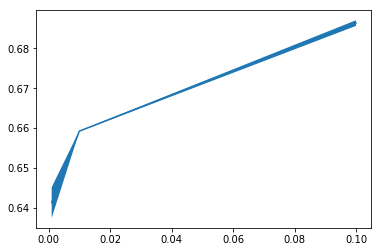

In [263]:
plt.plot(params['xgb__learning_rate'], gs.cv_results_['mean_test_score']);
plt.fill_between(params['xgb__learning_rate'],
                gs.cv_results_['mean_test_score'] - gs.cv_results_['std_test_score'],
                gs.cv_results_['mean_test_score'] + gs.cv_results_['std_test_score']);

Конечно надо изучать больше параметров, больше значений для каждого и на большем количестве фолдов, но тогда можно не успеть к дедлайну.

Посмотрим, что получилось на отложенной выборке.

In [265]:
y_pred = gs.predict_proba(df_test)[:,1]

In [266]:
print('ROC AUC базовой модели: {:.4f}'.format(roc_auc_score(df_test['target'], y_pred)))

ROC AUC базовой модели: 0.6870


Значение метрики на отложенной выборке очень близко к результату кросс-валидации. По сравнению с бейзлайном результат улучшился, но фактически только за счёт новых фич, поскольку на кросс-валидации лучшими оказались дефолтные параметры.

## 6. Выводы

Есть существенное пространство для улучшения результата по многим направлениям. Можно добавить фичу, которая будет содержать количество вылетов за небольшой период перед текущим рейсом, что будет отражать загруженность аэропорта в текущий момент. Есть открытые [данные](https://www.ncdc.noaa.gov/isd/data-access) о погоде вблизи аэропортов с часовой периодичностью — эту информацию можно использовать, чтобы оценивать вероятность задержки из-за плохой погоды. Безусловно необходимо провести более тщательную настройку гиперпараметров — в первую очередь количества деревьев в модели (``n_estimators``), максимальной глубины деревьев (``max_depth``).